In [1]:
from models import MVCNN
from tools import ImgDataset
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Calculating Importance

## Initialization

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = MVCNN.SVCNN('svcnn')
weights = torch.load('../test_results/MVCNN/trained-models/MVCNN/model-00030.pth', map_location=device)
model.load_state_dict(weights)
model.to(device)
model.eval()

SVCNN(
  (net_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [4]:
test_dataset = ImgDataset.MultiviewImgDataset(
    root_dir='../searching-algorithm/ModelNet40-12View/*/test',
    scale_aug=False,
    rot_aug=False,
    test_mode=True,
    num_models=0,
    num_views=12,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # Set batch_size to 1 to get all 12 views of a single model
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

In [5]:
# Extract CNN feature extractor from the model
feature_extractor = model.net_1
classifier = model.net_2

feature_extractor.eval()
classifier.eval()

num_views = 12  # Number of views per model

views are as

0, 1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9

## Accuracy Of Each View

In [34]:
ranking = {
    'view 0': [], 
    'view 1': [],
    'view 2': [],
    'view 3': [],
    'view 4': [],
    'view 5': [],
    'view 6': [],
    'view 7': [],
    'view 8': [],
    'view 9': [],
    'view 10': [],
    'view 11': []
}

In [35]:
!rm outputs

In [36]:
prev=torch.tensor([]).to(device)
for batch_idx, (target, data, data_path) in tqdm(enumerate(test_loader), total=len(test_loader)):
    data = data.to(device)
    target = target.to(device)
    for i, view in enumerate([0, 1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9]):
        view_data = data[:, view, :, :, :].squeeze(0)
        view_data = view_data.to(device)
        
        if torch.equal(view_data, prev):
            break
        
        with torch.no_grad():
            features = feature_extractor(view_data.unsqueeze(0))
            pooled = torch.max(features, dim=0)[0].unsqueeze(0)
            pooled = pooled.view(pooled.size(0), -1)
            
            with torch.no_grad():
                output = classifier(pooled)
            
            _, pred = torch.max(output, 1)
            out = (pred==target).float().item()
            ranking[f'view {view}'].append(out)
        
        prev = view_data
        
        with open ("outputs", 'a') as f:
            f.write(f"{data_path[i]} view {view}, {out}\n")

100%|██████████| 1860/1860 [02:33<00:00, 12.15it/s]


In [44]:
ranking = {view: sum(ranking[view]) / len(ranking[view]) if ranking[view] else 0.0 for view in ranking}

In [45]:
ranking

{'view 0': 0.8311827956989247,
 'view 1': 0.8623655913978494,
 'view 2': 0.8559139784946237,
 'view 3': 0.8521505376344086,
 'view 4': 0.853225806451613,
 'view 5': 0.8510752688172043,
 'view 6': 0.8516129032258064,
 'view 7': 0.8290322580645161,
 'view 8': 0.7919354838709678,
 'view 9': 0.8333333333333334,
 'view 10': 0.864516129032258,
 'view 11': 0.8521505376344086}

In [142]:
def min_max_norm(arr):
    max_val = max(arr)
    min_val = min(arr)
    return [(x-min_val) / (max_val - min_val) for x in arr]

def l1_norm(arr):
    norm = sum(abs(x) for x in arr)
    return [(x)*10 / norm for x in arr] if norm != 0 else arr

In [48]:
min_max_norm(list(ranking.values()))

[0.5407407407407404,
 0.9703703703703698,
 0.8814814814814821,
 0.8296296296296299,
 0.8444444444444451,
 0.8148148148148148,
 0.8222222222222216,
 0.5111111111111102,
 0.0,
 0.5703703703703706,
 1.0,
 0.8296296296296299]

In [49]:
l1_norm(list(ranking.values()))

[0.08206380381124263,
 0.08514252348850787,
 0.08450554700355645,
 0.08413397738733479,
 0.0842401401348267,
 0.08402781463984288,
 0.08408089601358883,
 0.08185147831625882,
 0.0781888635277881,
 0.08227612930622645,
 0.08535484898349169,
 0.08413397738733479]

## Accuracy While Removing Views

In [6]:
per_view_importance = {
    'view 0': [],
    'view 1': [],
    'view 2': [],
    'view 3': [],
    'view 4': [],
    'view 5': [],
    'view 6': [],
    'view 7': [],
    'view 8': [],
    'view 9': [],
    'view 10': [],
    'view 11': []
}
baseline_acc = 0
# Wrap test_loader with tqdm
for batch_idx, (target, data, _) in enumerate(tqdm(test_loader, desc="Batches")):
    data = data.to(device)  # shape: [1, 12, 3, 244, 244]
    target = target.to(device)

    all_views = data.squeeze(0)  # shape: [12, 3, 244, 244]

    # === Baseline ===
    all_feats = feature_extractor(all_views)  # shape: [12, C, H, W]
    pooled = torch.max(all_feats, dim=0)[0]  # shape: [C, H, W]
    pooled = pooled.unsqueeze(0)  # shape: [1, C, H, W]
    flattened = pooled.view(pooled.size(0), -1)  # shape: [1, C*H*W]
    with torch.no_grad():
        output = classifier(flattened)
    _, predicted = torch.max(output, 1)
    baseline_acc_batch = (predicted == target).float().item()

    # if batch_idx % 100 == 0:
        # print(f"Processed {batch_idx} batches, current average baseline accuracy: {sum_baseline / (batch_idx + 1):.4f}")

    # === Per-View Importance ===
    for view in tqdm([0, 1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9], desc=f"View removal batch {batch_idx}", leave=False):
        views_removed = torch.cat([all_views[:view], all_views[view+1:]], dim=0)
        feats = feature_extractor(views_removed)
        pooled = torch.max(feats, dim=0)[0].unsqueeze(0)
        flattened = pooled.view(pooled.size(0), -1)
        with torch.no_grad():
            output = classifier(flattened)
        _, predicted = torch.max(output, 1)
        acc = (predicted == target).float().item()
        
        per_view_importance[f'view {view}'].append(acc)
        baseline_acc += baseline_acc_batch
        # print(f"View {view} removed, accuracy: {acc:.4f}, baseline: {baseline_acc:.4f}")

Batches:   0%|          | 0/1860 [00:00<?, ?it/s]

Batches: 100%|██████████| 1860/1860 [16:00<00:00,  1.94it/s]


In [140]:
len(per_view_importance)

12

In [141]:
baseline_acc/(1860*12)

0.5844086021505376

In [18]:
for view in per_view_importance:
    print(view,"," ,sum(per_view_importance[view]) / len(per_view_importance[view])) if per_view_importance[view] else 0.0

view 0 , 0.5870967741935483
view 1 , 0.5946236559139785
view 2 , 0.5989247311827957
view 3 , 0.5946236559139785
view 4 , 0.6005376344086022
view 5 , 0.5967741935483871
view 6 , 0.5908602150537634
view 7 , 0.5919354838709677
view 8 , 0.5978494623655914
view 9 , 0.5951612903225807
view 10 , 0.5887096774193549
view 11 , 0.6021505376344086


In [143]:
min_max_norm([sum(per_view_importance[view]) for view in per_view_importance])

[0.0,
 0.5,
 0.7857142857142857,
 0.5,
 0.8928571428571429,
 0.6428571428571429,
 0.25,
 0.32142857142857145,
 0.7142857142857143,
 0.5357142857142857,
 0.10714285714285714,
 1.0]

In [181]:
max_l1 = max(sum(per_view_importance[view])/len(per_view_importance[view]) for view in per_view_importance)
min_l1 = min(sum(per_view_importance[view])/len(per_view_importance[view]) for view in per_view_importance)
min_l1+max_l1

1.189247311827957

In [182]:
def l1_norm(arr):
    norm = sum(abs(x) for x in arr)
    return [x / (norm) for x in arr] if norm != 0 else arr

In [184]:
l1_norm(([sum(per_view_importance[view])/len(per_view_importance[view]) for view in per_view_importance]))

[0.08223510806536635,
 0.08328940432261465,
 0.08389185932675652,
 0.08328940432261465,
 0.08411777995330974,
 0.0835906318246856,
 0.0827622561939905,
 0.08291286994502597,
 0.08374124557572106,
 0.0833647111981324,
 0.08246102869191957,
 0.08434370057986294]

In [192]:
norms = [0.08223510806536635,
    0.08328940432261465,
    0.08389185932675652,
    0.08328940432261465,
    0.08411777995330974,
    0.0835906318246856,
    0.0827622561939905,
    0.08291286994502597,
    0.08374124557572106,
    0.0833647111981324,
    0.08246102869191957,
    0.08434370057986294]
norms = [1-min_l1+max_l1-x for x in norms]

In [193]:
norms

[0.9328186553754939,
 0.9317643591182456,
 0.9311619041141037,
 0.9317643591182456,
 0.9309359834875506,
 0.9314631316161747,
 0.9322915072468698,
 0.9321408934958343,
 0.9313125178651392,
 0.9316890522427279,
 0.9325927347489407,
 0.9307100628609973]

In [194]:
def find_imp(arr):
    mean = sum(abs(x) for x in arr)/len(arr)
    return [(mean)/x for x in arr] if mean != 0 else arr

In [195]:
find_imp(norms)

[0.9988226808483747,
 0.9999528539482233,
 1.0005998161984029,
 0.9999528539482233,
 1.0008426429248525,
 1.0002762304621824,
 0.9993874478798704,
 0.9995489272155731,
 1.0004379971648214,
 1.000033678473224,
 0.9990646456819668,
 1.0010855875388558]

In [172]:
find_imp([sum(per_view_importance[view]) for view in per_view_importance])

[1.0133547008547008,
 1.0005274261603374,
 0.9933423099940155,
 1.0005274261603374,
 0.9906744255446135,
 0.9969219219219219,
 1.006900212314225,
 1.0050711474417195,
 0.995128896882494,
 0.9996236073471845,
 1.0105783866057838,
 0.9880208333333332]

In [136]:
sum(find_imp([sum(per_view_importance[view]) for view in per_view_importance]))

12.000671294560666

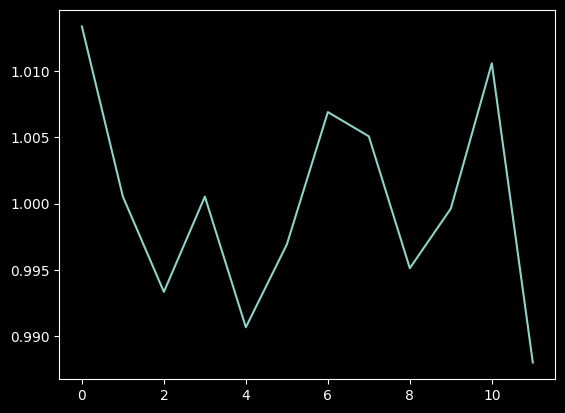

In [137]:
plt.plot(find_imp([sum(per_view_importance[view]) for view in per_view_importance]))

## Accuarcy of Whole MVCNN Model

In [13]:
test_dataset = ImgDataset.MultiviewImgDataset(
    root_dir='../searching-algorithm/ModelNet40-12View/*/train',
    scale_aug=False,
    rot_aug=False,
    test_mode=True,
    num_models=0,
    num_views=12,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

In [15]:
correct = 0
total = 0

pbar = tqdm(test_loader, desc="Testing", leave=False, unit="batch")

for label, data, _ in pbar:
    data = data.to(device)
    label = label.to(device)

    with torch.no_grad():
        features = feature_extractor(data.squeeze(0))  # shape: [12, C, H, W]
        pooled = torch.max(features, dim=0)[0].unsqueeze(0)
        pooled = pooled.view(pooled.size(0), -1)
        output = classifier(pooled)

    _, pred = torch.max(output, 1)
    correct += (pred == label).float().item()
    total += 1

    acc = correct / total
    pbar.set_postfix(acc=f"{acc:.4f}")

print(f"Final Accuracy: {correct / total:.4f}")

Final Accuracy: 0.6611
